In [9]:
import torch
import torch.nn.functional as F
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from momaapi import MOMA
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [2]:
def mean_similarity(x, y):
    # x: n x d
    # y: m x d
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    
    return torch.mm(x, y.t()).mean()

def smooth_chamfer_similarity(x, y):
    # x: n x d
    # y: m x d
    alpha = 16
    
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    c = torch.mm(x, y.t())
    
    x_sc_sim = torch.logsumexp(alpha*c, dim=1).sum() / (2.*alpha*x.shape[0])
    y_sc_sim = torch.logsumexp(alpha*c, dim=0).sum() / (2.*alpha*y.shape[0])
    
    return x_sc_sim + y_sc_sim

In [3]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [13]:
id2emb = {}
moma = MOMA("/data/dir_moma/")

ids_train = moma.get_ids_act(split="train")
ids_val = moma.get_ids_act(split="val")
ids_test = moma.get_ids_act(split="test")
ids_act = ids_train + ids_val + ids_test

for act in tqdm(moma.get_anns_act(ids_act=ids_act)):
    # if split == "train" and act.id == "1YzGUyM3P2k":
    #     continue

    captions = []
    for sact in moma.get_anns_sact(act.ids_sact):
        if captions and sact.cname == captions[-1]:
            continue
        captions.append(sact.cname)
        
    with torch.no_grad():
        emb = model.encode(captions) # n x d
        id2emb[act.id] = torch.from_numpy(emb)      

100%|██████████| 1412/1412 [00:41<00:00, 33.76it/s]


100%|██████████| 1411/1411 [02:25<00:00,  9.70it/s] 


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

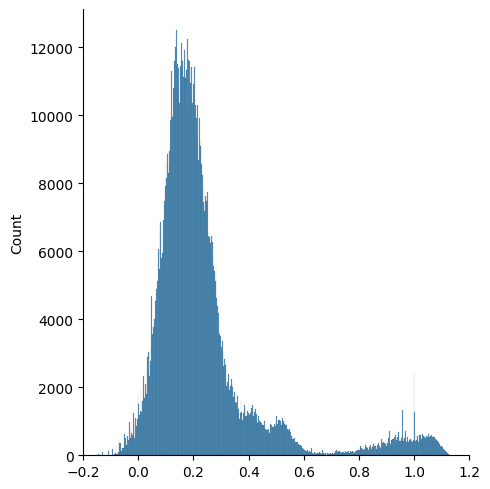

In [30]:
similarity = []
for i in tqdm(range(len(ids_act)-1)):
    for j in range(i+1, len(ids_act)):
        x = id2emb[ids_act[i]]
        y = id2emb[ids_act[j]]
        # similarity.append(mean_similarity(x, y))
        similarity.append(smooth_chamfer_similarity(x, y))
        
# sns.heatmap(np.array(similarity))
sns.displot(np.array(similarity))
plt.xlim([-0.2, 1.2])

print(f"larger than 0.5: {(np.array(similarity) > 0.5).sum()}")

In [21]:
def DTW(p, q, sim):
    D = np.zeros((len(p) + 1, len(q) + 1))

    for i in range(1, len(p)+1):
        for j in range(1, len(q)+1):
            s = sim[p[i-1], q[j-1]]
            D[i,j] = max(D[i-1,j], D[i,j-1], D[i-1,j-1] + s)

    path, count = backtrack(p, q, sim, D)

    return D, path, count

def backtrack(p, q, sim, D):
    path, count = [], 0
    i, j = len(p), len(q)

    while i >= 1 and j >= 1:
        path.append((i-1, j-1))
        s = sim[p[i-1], q[j-1]]
        if D[i,j] == D[i-1,j]:
            i = i -1
        elif D[i,j] == D[i,j-1]:
            j = j - 1
        elif D[i,j] == D[i-1,j-1] + s:
            i, j = i - 1, j - 1
            count += 1
        else:
            raise ValueError
        
    return path[::-1], count

In [22]:
# PREPROCESSING

moma = MOMA(dir_moma="/data/dir_moma/", paradigm="standard")

vid2seq = {}   # activity id -> sub-activity sequence
sid2cname = {} # sub-activity id -> sub-activity class name
for split in ["train", "val", "test"]:
    ids_act = moma.get_ids_act(split=split)
    for act in tqdm(moma.get_anns_act(ids_act=ids_act), desc=f"PREPROCESSING ({split})"):
        sact_seq = []
        for sact in moma.get_anns_sact(ids_sact=act.ids_sact):
            sid2cname[sact.cid] = sact.cname
            sact_seq.append(sact.cid)
        vid2seq[act.id] = np.array(sact_seq)

sid2cemb = {} # sub-activity id -> sub-activity caption embedding
sbert = SentenceTransformer("all-MiniLM-L6-v2")
for vid, cname in sid2cname.items():
    cemb = sbert.encode(cname)
    cemb = torch.from_numpy(cemb).float()
    sid2cemb[vid] = cemb
    
cembs = torch.zeros(len(sid2cemb), 384)
for idx, emb in sid2cemb.items():
    cembs[idx] = emb

cembs = F.normalize(cembs, dim=-1)
sim = torch.mm(cembs, cembs.t())
sim = sim.numpy()

PREPROCESSING (test): 100%|██████████| 282/282 [00:01<00:00, 189.65it/s]


  0%|          | 0/1411 [00:00<?, ?it/s]

100%|██████████| 1411/1411 [02:42<00:00,  8.68it/s] 


larger than 0.5: 63926


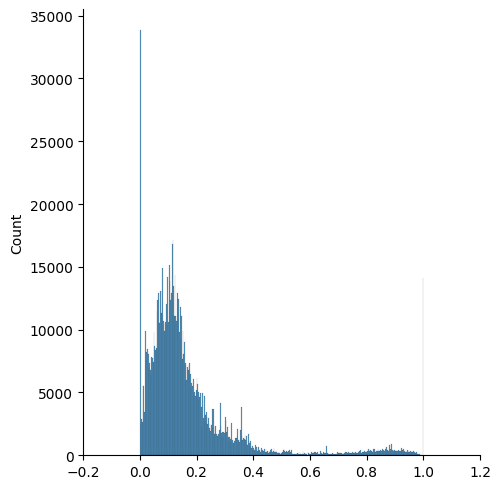

In [27]:
ids_train = moma.get_ids_act(split="train")
ids_val = moma.get_ids_act(split="val")
ids_test = moma.get_ids_act(split="test")
ids_act = ids_train + ids_val + ids_test

similarity = []
for i in tqdm(range(len(ids_act)-1)):
    for j in range(i+1, len(ids_act)):
        p = vid2seq[ids_act[i]]
        q = vid2seq[ids_act[j]]
        D, path, count = DTW(p, q, sim)
        if count > 0:
            normalized_distance = D[len(p), len(q)] / count
        else:
            normalized_distance = D[len(p), len(q)]
        similarity.append(normalized_distance)
        
# sns.heatmap(np.array(similarity))
sns.displot(np.array(similarity))
plt.xlim([-0.2, 1.2])

print(f"larger than 0.5: {(np.array(similarity) > 0.5).sum()}")